## Imports, loading model and SAE

In [7]:
# general imports
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "4,5,6,7"
import torch
from tqdm import tqdm
import plotly.express as px

torch.set_grad_enabled(False);
# package import
from torch import Tensor
from transformer_lens import utils
from functools import partial
from jaxtyping import Int, Float

In [8]:
from transformer_lens import HookedTransformer
from sae_lens import SAE
from torch.nn.parallel import DataParallel

# Choose a layer you want to focus on
# For this tutorial, we're going to use layer 2
layer = 8

model = HookedTransformer.from_pretrained("gpt2-small").to('cuda')

# Initialize SAE
layer = 8
sae, cfg_dict, _ = SAE.from_pretrained(
    release="gpt2-small-res-jb",
    sae_id=f"blocks.{layer}.hook_resid_pre",
    device= "cuda:0"
)

# get hook point
hook_point = sae.cfg.hook_name
print(hook_point)

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda
blocks.8.hook_resid_pre


In [9]:
import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda}")

PyTorch Version: 2.1.0a0+32f93b1
CUDA Available: True
CUDA Version: 12.2


## Get the directions used by the SAE for classification

In [10]:
def get_top_k_active_directions_encoder(sae: SAE, activation: torch.Tensor, k: int) -> torch.Tensor:
    activation = activation.to(sae.W_enc.device)
    latent = sae.encode(activation)
    _, top_k_indices = torch.topk(latent.abs().squeeze(), k)
    top_k_directions = sae.W_enc.T[top_k_indices].T
    unit_vectors = torch.nn.functional.normalize(top_k_directions, p=2, dim=1)
    return unit_vectors

In [11]:
def get_top_k_active_directions(sae: SAE, activation: torch.Tensor, k: int) -> torch.Tensor:
    activation = activation.to(sae.W_dec.device)
    latent = sae.encode(activation)
    _, top_k_indices = torch.topk(latent.abs().squeeze(), k)
    top_k_directions = sae.W_dec[top_k_indices].T
    unit_vectors = torch.nn.functional.normalize(top_k_directions, p=2, dim=1)
    return unit_vectors

In [12]:
import torch
from transformer_lens import HookedTransformer
from sae_lens import SAE

def get_last_token_directions(model: HookedTransformer, sae: SAE, prompt: str, k: int = 5) -> torch.Tensor:
    # Tokenize the prompt
    tokens = model.to_tokens(prompt, prepend_bos=True)
    
    # Run the model and get the cache
    _, cache = model.run_with_cache(tokens)
    
    # Get the activation for the last token
    last_token_activation = cache[sae.cfg.hook_name][:, -1, :]
    
    # Get the top k active directions
    top_k_directions = get_top_k_active_directions(sae, last_token_activation, k)
    
    return top_k_directions


prompt = "The capital of France is"
k = 5

try:
    top_directions = get_last_token_directions(model, sae, prompt, k)
    print("Successfully computed top directions")
    print(f"Top directions shape: {top_directions.shape}")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()

# If successful, compute angles
if 'top_directions' in locals():
    angles = torch.zeros((k, k))
    for i in range(k):
        for j in range(k):
            cos_similarity = torch.dot(top_directions[i], top_directions[j])
            angle = torch.acos(torch.clamp(cos_similarity, -1, 1)) * 180 / torch.pi
            angles[i, j] = angle

    print("\nAngles between directions (in degrees):")
    print(angles)


Successfully computed top directions
Top directions shape: torch.Size([768, 5])

Angles between directions (in degrees):
tensor([[0.0000e+00, 9.9523e+01, 4.1458e+01, 9.0548e+01, 4.2074e+01],
        [9.9523e+01, 0.0000e+00, 9.5730e+01, 1.2192e+02, 6.0995e+01],
        [4.1458e+01, 9.5730e+01, 1.9782e-02, 8.2484e+01, 5.5891e+01],
        [9.0548e+01, 1.2192e+02, 8.2484e+01, 0.0000e+00, 9.9317e+01],
        [4.2074e+01, 6.0995e+01, 5.5891e+01, 9.9317e+01, 1.9782e-02]])


## Get the most functionally significant directions according to CBE

In [13]:
import torch as th
import torch.nn.functional as F
from typing import NamedTuple, Literal, Callable
from tqdm.auto import tqdm

class CausalBasis(NamedTuple):
    energies: th.Tensor
    vectors: th.Tensor

def compute_direction_mean(
    batch: dict,
    model: th.nn.Module,
    layer_index: int,
    direction: th.Tensor
) -> float:
    total_projection = 0.0
    total_tokens = 0

    with th.no_grad():
        input_ids = batch["input_ids"].to(direction.device)
        attention_mask = batch["attention_mask"].to(direction.device)

        _, cache = model.run_with_cache(input_ids, attention_mask=attention_mask)
        activations = cache[f"blocks.{layer_index}.hook_resid_pre"]

        # Project activations onto the direction
        projection = th.einsum("bld,d->bl", activations, direction)
        
        # Apply attention mask and sum
        masked_projection = projection * attention_mask
        batch_sum = masked_projection.sum()
        batch_tokens = attention_mask.sum()

        total_projection += batch_sum.item()
        total_tokens += batch_tokens.item()

    return total_projection / total_tokens


In [14]:
import torch as th

def remove_subspace(u: th.Tensor, v: th.Tensor, direction_mean: th.Tensor, mode: str = "mean") -> th.Tensor:
    v = v.squeeze()  # Ensure v is 1D
    v_normalized = v / v.norm()
    if mode == "mean":
        proj_u = th.einsum("bi,i->b", u, v_normalized).unsqueeze(1) * v_normalized.unsqueeze(0)
        result = u - proj_u + direction_mean
        
    elif mode == "zero":
        result = u - th.einsum("bi,i->b", u, v_normalized).unsqueeze(1) * v_normalized.unsqueeze(0)
    else:
        raise ValueError(f"Unknown mode {mode}")
    return result

In [15]:
import torch as th
from typing import Literal, Callable, NamedTuple
from tqdm import tqdm
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import einops

class CausalBasis(NamedTuple):
    energies: th.Tensor
    vectors: th.Tensor

def extract_causal_bases(
    model: th.nn.Module,
    activation: th.Tensor,
    layer_index: int,
    dataset_loader: Callable,
    k: int,
    max_iter: int = 10,
    mode: Literal["mean", "zero"] = "mean",
) -> CausalBasis:
    device = activation.device
    dtype = activation.dtype
    d = activation.shape[-1]

    activation = activation.detach().requires_grad_(True)
    basis = CausalBasis(
        th.zeros(k, device=device),
        th.randn(d, k, device=device, dtype=dtype),
    )

    eye = th.eye(d, device=device, dtype=dtype)
    
    basis_losses_hist = []
    for j in range(k):
        if j:
            A = basis.vectors[:, :j]
            proj = eye - A @ A.T
        else:
            proj = eye

        def project(x: th.Tensor) -> th.Tensor:
            # Project away from previously identified basis vectors
            x = proj @ x
            # Project to the unit sphere
            return x / (x.norm() + th.finfo(x.dtype).eps)

        v = th.nn.Parameter(project(basis.vectors[:, j].clone()))
        optimizer = th.optim.Adam([v], lr=0.005)
        #optimizer = th.optim.LBFGS([v], line_search_fn="strong_wolfe", max_iter=1)
        
        loss_history = []
        if j > 1:
            max_iter = 100
        for _ in range(max_iter):
            def closure():
                optimizer.zero_grad(set_to_none=True)
                v_proj = project(v)  # Project v before using it
                direction_mean = 0.2 * ((th.einsum('bi,i->b', activation, v_proj) / th.dot(v_proj, v_proj)).unsqueeze(1) * v_proj.unsqueeze(0))

                ablated_activation = remove_subspace(activation, v_proj, direction_mean, mode=mode)

                original_outputs = compute_subsequent_outputs_logits_only(model, activation, layer_index)
                ablated_outputs = compute_subsequent_outputs_logits_only(model, ablated_activation, layer_index) 

                similarity, avg_msd, kl_div = compute_functional_similarity_logits_only(
                    original_outputs,
                    ablated_outputs,
                )
                loss_history.append(kl_div)
                loss = -similarity
                
                if th.isfinite(loss):
                    loss.backward(create_graph=False)
                else:
                    print(f"Warning: Invalid similarity measure: {similarity.item()}")
                    loss = th.tensor(0.0, device=device)
                return loss

            optimizer.step(closure)

        with th.no_grad():
            basis.vectors[:, j] = project(v.data)  # Ensure the final vector is projected
            v_normalized = basis.vectors[:, j]
            direction_mean = 0.2 * (th.einsum('bi,i->b', activation, v_normalized) / th.dot(v_normalized, v_normalized)).unsqueeze(1) * v_normalized.unsqueeze(0)

            ablated_activation = remove_subspace(activation, v_normalized, direction_mean, mode=mode)
            original_outputs = compute_subsequent_outputs_logits_only(model, activation, layer_index)
            ablated_outputs = compute_subsequent_outputs_logits_only(model, ablated_activation, layer_index)

            similarity, avg_msd, kl_div = compute_functional_similarity_logits_only(
                original_outputs,
                ablated_outputs,
            )
            
            basis.energies[j] = similarity.item()
        
        basis_losses_hist.append(loss_history)
        del v, optimizer, direction_mean, ablated_activation, original_outputs, ablated_outputs, similarity, avg_msd, kl_div
        th.cuda.empty_cache()

    # Sort basis vectors by descending energy
    indices = basis.energies.argsort(descending=True)
    return CausalBasis(basis.energies[indices], basis.vectors[:, indices]), basis_losses_hist


def compute_functional_similarity(orig_activations, abl_activations, orig_logits, abl_logits, beta=0):
    # Compute mean squared difference for each layer's activations
    msd_list = []
    for orig_act, abl_act in zip(orig_activations[:-1], abl_activations[:-1]):  # Exclude logits
        msd = th.mean((th.norm(orig_act) - th.norm(abl_act))**2)
        msd_list.append(msd)
    
    # Average mean squared difference across layers
    if msd_list:
        avg_msd = th.mean(th.stack(msd_list))
    else:
        # If there are no intermediate activations, use only the logits
        avg_msd = th.mean((orig_logits - abl_logits) ** 2)

    orig_logits_flat = einops.rearrange(orig_logits, "... vocab -> (...) vocab")
    abl_logits_flat = einops.rearrange(abl_logits, "... vocab -> (...) vocab")

    
    # Compute KL divergence for logits
    kl_div = F.kl_div(
        F.log_softmax(abl_logits_flat, dim=-1),
        F.log_softmax(orig_logits_flat, dim=-1),
        log_target=True,
        reduction="batchmean",
    )
    # Combine average MSD and KL divergence
    # Note: We use negative MSD because we want to maximize similarity (minimize difference)
    similarity = beta * avg_msd + (1 - beta) * kl_div
    
    return similarity, avg_msd, kl_div

def compute_functional_similarity_logits_only(orig_logits, abl_logits, beta=0):
    orig_logits_flat = einops.rearrange(orig_logits, "... vocab -> (...) vocab")
    abl_logits_flat = einops.rearrange(abl_logits, "... vocab -> (...) vocab")

    # Compute KL divergence for logits
    kl_div = F.kl_div(
        F.log_softmax(abl_logits_flat, dim=-1),
        F.log_softmax(orig_logits_flat, dim=-1),
        log_target=True,
        reduction="batchmean",
    )
    similarity = kl_div
    
    return similarity, 0, kl_div

def compute_subsequent_outputs(model: th.nn.Module, activation: th.Tensor, layer_index: int) -> list[th.Tensor]:
    outputs = [activation]  # Include the initial activation

    if activation.ndim == 2:
        activation = activation.unsqueeze(1)  # Add pos dimension if missing

    current_activation = activation

    for block in model.blocks[layer_index+1:]:
        # Pass through the complete block
        current_activation = block(current_activation)
        outputs.append(current_activation)

    # Apply the final layer normalization
    current_activation = model.ln_final(current_activation)

    # Compute the logits
    logits = model.unembed(current_activation)
    outputs.append(logits)

    return outputs

def compute_subsequent_outputs_logits_only(model: th.nn.Module, activation: th.Tensor, layer_index: int) -> list[th.Tensor]:
    if activation.ndim == 2:
        activation = activation.unsqueeze(1) 
    current_activation = activation

    for block in model.blocks[layer_index+1:]:
        current_activation = block(current_activation)
    current_activation = model.ln_final(current_activation)
    logits = model.unembed(current_activation)

    return logits


## Load example prompts

In [16]:
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset

class PromptDataset(Dataset):
    def __init__(self, prompts, tokenizer, max_length=512):
        self.encoded_prompts = tokenizer(prompts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

    def __len__(self):
        return len(self.encoded_prompts['input_ids'])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encoded_prompts.items()}
    
def create_dataset_loader(prompts, model, batch_size=3):
    dataset = PromptDataset(prompts, model.tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# Define a function to get short sentences
def get_short_sentences(max_length=10, num_sentences=100):
    dataset = load_dataset('bookcorpus', split='train', streaming=True)
    short_sentences = []

    for example in dataset:
        sentences = example['text'].split('.')
        for sentence in sentences:
            words = sentence.strip().split()
            if 0 < len(words) <= max_length:
                short_sentences.append(sentence.strip())
            if len(short_sentences) >= num_sentences:
                return short_sentences

    return short_sentences


## Compare relative causal effect of SAE directions and CBE directions

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

def relative_causal_effect(model, sae, layer_index, dataloader, k_sae=3, k_cbe=3):
    all_relative_effects = []
    sae_energies = []
    cbe_energies = []
    all_loss_histories = []
    
    for batch in tqdm(dataloader, desc="Processing batches"):
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        
        with torch.no_grad():
            _, cache = model.run_with_cache(input_ids, attention_mask=attention_mask)
        
        last_token_activation = cache[sae.cfg.hook_name][:, -1, :]
        
        # Process each sample in the batch
        for i in range(last_token_activation.shape[0]):
            sample_activation = last_token_activation[i].unsqueeze(0)
            
            
            # Get CBE directions
            causal_basis, loss_history = extract_causal_bases(
                model=model,
                activation=sample_activation,
                layer_index=layer_index,
                dataset_loader=None,
                k=k_cbe,
                max_iter=200,
                mode="mean"
            )
            
            sae_directions = get_top_k_active_directions(sae, sample_activation, k_sae)
            for j in range(k_sae):
                v = sae_directions[:, j].clone()
                
                with torch.no_grad():
                    direction_mean = 0.2 * ((th.einsum('bi,i->b', sample_activation, v) / th.dot(v, v)).unsqueeze(1) * v.unsqueeze(0))
                    ablated_activation_sae = remove_subspace(sample_activation, v, direction_mean, mode="mean")

                    original_outputs = compute_subsequent_outputs_logits_only(model, sample_activation, layer_index)
                    ablated_outputs_sae = compute_subsequent_outputs_logits_only(model, ablated_activation_sae, layer_index)

                    similarity_sae, _, _ = compute_functional_similarity_logits_only(
                        #original_outputs,
                        #ablated_outputs_sae,
                        original_outputs,#[-1],
                        ablated_outputs_sae,#[-1]
                    )
                
                cbe_energy = causal_basis.energies[j].item()
                relative_effect = cbe_energy / (similarity_sae.item())
                sae_energies.append(similarity_sae.item())
                cbe_energies.append(cbe_energy)
                all_relative_effects.append(relative_effect)
                all_loss_histories.append(loss_history)

                
                del v, ablated_activation_sae, original_outputs, ablated_outputs_sae, similarity_sae
            del sample_activation, sae_directions, causal_basis
        del input_ids, attention_mask, cache, last_token_activation
        torch.cuda.empty_cache()
        gc.collect()

    
    return all_relative_effects, sae_energies, cbe_energies, loss_history

# Run the multi-prompt comparison
prompts = get_short_sentences(max_length=15, num_sentences=50)  # Assuming this function is defined
dataloader = create_dataset_loader(prompts, model, batch_size=2)
layer_index = 8

all_relative_effects, sae_energies, cbe_energies, al_loss_histories = relative_causal_effect(model, sae, layer_index, dataloader)


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for bookcorpus contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bookcorpus
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Processing batches: 100%|██████████| 25/25 [11:17<00:00, 27.12s/it]


In [21]:
import math
def remove_lowest_element(data):
    if not data:
        raise ValueError("The data list is empty.")
    
    # Sort the list
    sorted_data = sorted(data)
    sorted_data = [item for item in sorted_data if not math.isnan(item)]
    # Remove the lowest element
    sorted_data.pop(-1)
    
    return sorted_data

[tensor(3.9890e-05, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0140, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0742, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.2830, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.8457, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.9515, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.5825, device='cuda:0', grad_fn=<DivBackward0>), tensor(5.6015, device='cuda:0', grad_fn=<DivBackward0>), tensor(7.9275, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.5157, device='cuda:0', grad_fn=<DivBackward0>), tensor(13.3259, device='cuda:0', grad_fn=<DivBackward0>), tensor(16.3401, device='cuda:0', grad_fn=<DivBackward0>), tensor(19.5688, device='cuda:0', grad_fn=<DivBackward0>), tensor(23.0336, device='cuda:0', grad_fn=<DivBackward0>), tensor(26.8090, device='cuda:0', grad_fn=<DivBackward0>), tensor(31.1949, device='cuda:0', grad_fn=<DivBackward0>), tensor(36.8092, dev

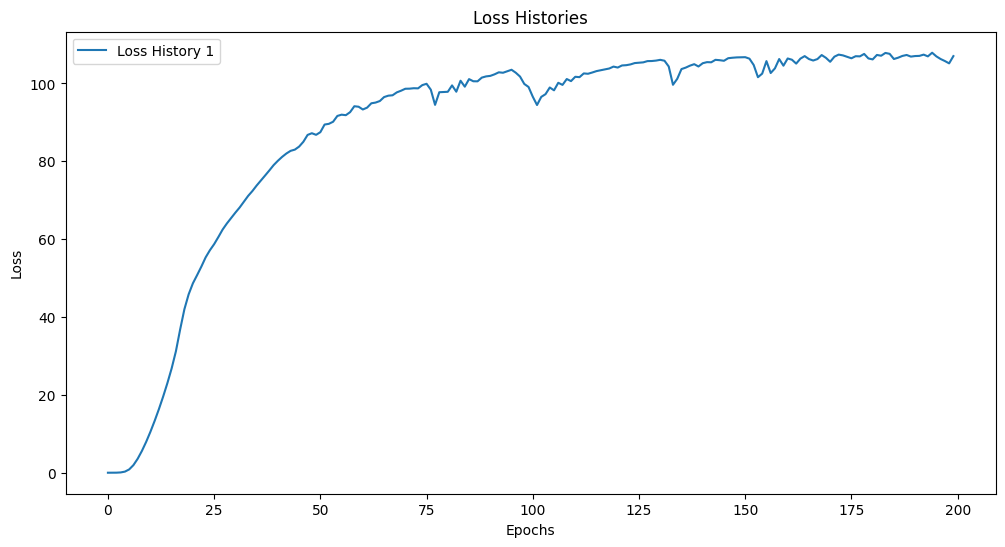

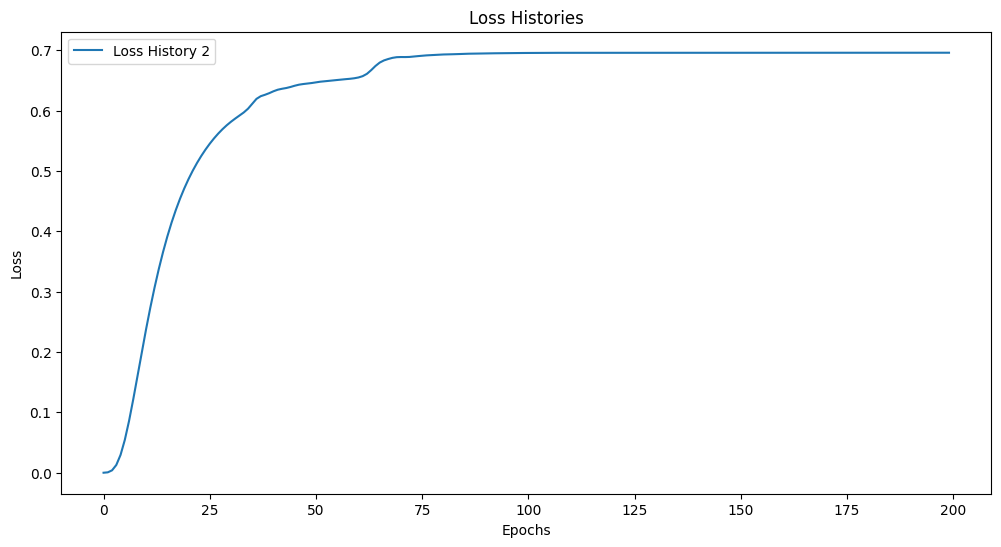

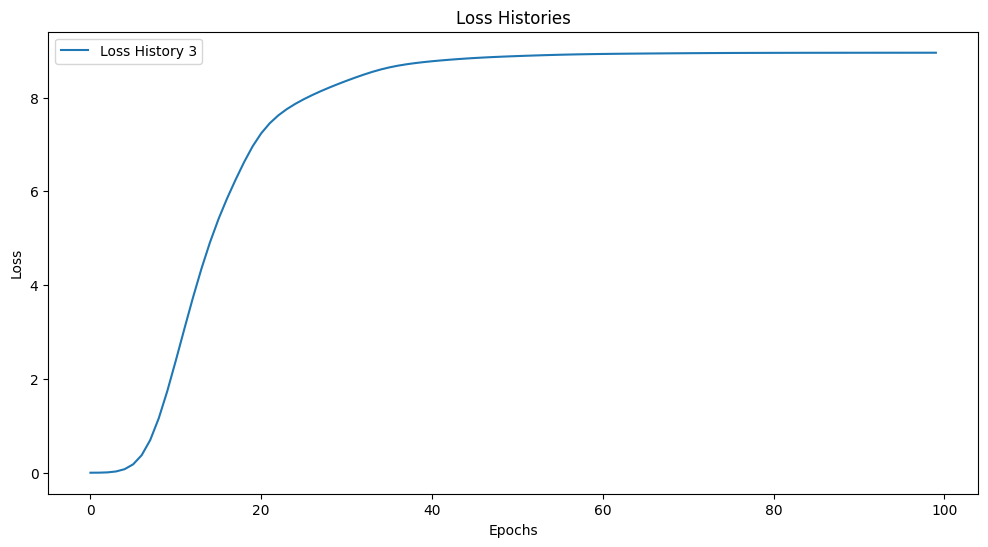

In [58]:

print(al_loss_histories[0])
print(al_loss_histories[1])
print(al_loss_histories[2])
# Plot each loss history
for i, basis_loss_histories in enumerate(al_loss_histories):
    basis_losses = [x.item() for x in basis_loss_histories]
    plt.figure(figsize=(12, 6))
    plt.plot(basis_losses, label=f'Loss History {i+1}')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Histories')
    plt.show()

[tensor(0.0080), tensor(0.0070), tensor(0.0124), tensor(0.0078), tensor(0.0077), tensor(0.0179), tensor(0.0080), tensor(0.0059), tensor(0.0189), tensor(0.0078), tensor(0.0069), tensor(0.0114), tensor(0.0092), tensor(0.0062), tensor(0.0152), tensor(0.0083), tensor(0.0055), tensor(0.0175), tensor(0.0061), tensor(0.0086), tensor(0.0411), tensor(0.0064), tensor(0.0058), tensor(0.0141), tensor(0.0071), tensor(0.0052), tensor(0.0265), tensor(0.0212), tensor(0.0530), tensor(0.0427), tensor(0.0084), tensor(0.0061), tensor(0.0132), tensor(0.0067), tensor(0.0060), tensor(0.0179), tensor(0.0083), tensor(0.0072), tensor(0.0117), tensor(0.0313), tensor(0.0027), tensor(0.0510), tensor(0.0064), tensor(0.0088), tensor(0.0293), tensor(0.0082), tensor(0.0096), tensor(0.0111), tensor(0.0060), tensor(0.0069), tensor(0.0130), tensor(0.0095), tensor(0.0070), tensor(0.0214), tensor(0.0100), tensor(0.0075), tensor(0.0181), tensor(0.0082), tensor(0.0051), tensor(0.0196), tensor(0.0103), tensor(0.0094), tensor(

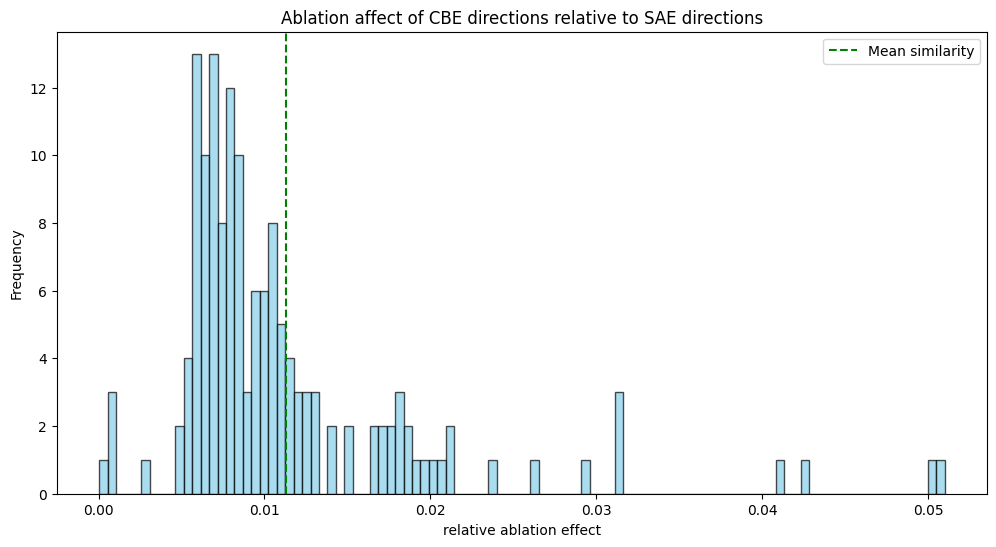

cbe: [85.24172973632812, 63.86164093017578, 19.506126403808594, 85.23694610595703, 56.01044464111328, 14.516866683959961, 86.90931701660156, 78.37234497070312, 13.47271728515625, 92.1629409790039, 65.71697235107422, 25.568096160888672, 79.42328643798828, 74.72909545898438, 20.834529876708984, 89.85064697265625, 84.97894287109375, 17.997589111328125, 118.35417938232422, 52.711238861083984, 7.019223213195801, 112.73065185546875, 76.88871002197266, 20.349063873291016, 98.54081726074219, 88.294189453125, 9.862688064575195, 51.750953674316406, 21.0644474029541, 11.88668441772461, 84.98304748535156, 79.25691223144531, 19.405086517333984, 103.74783325195312, 76.98747253417969, 13.536325454711914, 84.43702697753906, 63.81952667236328, 20.940277099609375, 54.38805389404297, 18.888242721557617, 7.0624775886535645, 107.88497924804688, 54.911865234375, 8.943119049072266, 87.4706802368164, 47.70252990722656, 24.327430725097656, 120.22157287597656, 66.87075805664062, 21.114971160888672, 76.189910888

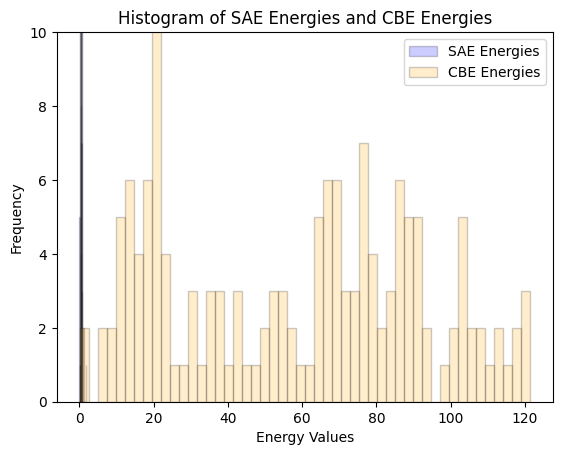

In [25]:
# Plot the distribution of similarities
#all_relative_effects_scalars = [t.item() for t in all_relative_effects]
plt.figure(figsize=(12, 6))
all_relative_effects = [1/x for x in all_relative_effects]
plt.hist(remove_lowest_element(all_relative_effects), bins=100, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(remove_lowest_element(all_relative_effects)), color='g', linestyle='--', label='Mean similarity')
plt.xlabel('relative ablation effect')
plt.ylabel('Frequency')
plt.title(f'Ablation affect of CBE directions relative to SAE directions')
plt.legend()
print([torch.tensor(scalar) for scalar in all_relative_effects])
print(np.mean([torch.tensor(scalar) for scalar in all_relative_effects]))
plt.show()



# Plot SAE energies
print(f"cbe: {cbe_energies}")
print(f"sae: {sae_energies}")
      
plt.hist(sae_energies, bins=50, alpha=0.2, color='blue', edgecolor='black', label='SAE Energies')
plt.hist(cbe_energies, bins=50, alpha=0.2, color='orange', edgecolor='black', label='CBE Energies')
plt.legend()
plt.xlabel('Energy Values')
plt.ylabel('Frequency')
plt.title('Histogram of SAE Energies and CBE Energies')
#plt.xlim(left=-0.1, right=0.1)
plt.ylim(bottom=0, top=10) 
plt.show()

All relative effects:
[tensor(0.0001), tensor(6.8395e-07), tensor(5.8222e-06), tensor(0.0001), tensor(9.9452e-07), tensor(1.0688e-06), tensor(0.0001), tensor(1.1249e-06), tensor(4.5492e-06), tensor(0.0001), tensor(2.6246e-07), tensor(8.8349e-07), tensor(0.0002), tensor(8.7746e-07), tensor(1.7296e-07), tensor(0.0001), tensor(1.0731e-06), tensor(1.2237e-07), tensor(0.0001), tensor(7.5007e-07), tensor(5.0033e-07), tensor(0.0002), tensor(5.4305e-07), tensor(2.2270e-07), tensor(0.0001), tensor(8.0293e-07), tensor(4.2778e-06), tensor(2.5421e-05), tensor(0.0001), tensor(0.0003), tensor(0.0001), tensor(1.2211e-06), tensor(1.4465e-06), tensor(8.6243e-05), tensor(1.0294e-06), tensor(3.7388e-06), tensor(9.1307e-05), tensor(8.7419e-07), tensor(6.9349e-06), tensor(0.0001), tensor(6.3487e-06), tensor(4.0573e-06), tensor(7.9929e-05), tensor(9.0617e-07), tensor(6.6423e-07), tensor(0.0001), tensor(7.5973e-07), tensor(2.2925e-06), tensor(0.0002), tensor(8.6508e-07), tensor(3.8883e-06), tensor(0.0001), t

/tmp/ipykernel_2998609/3556025715.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


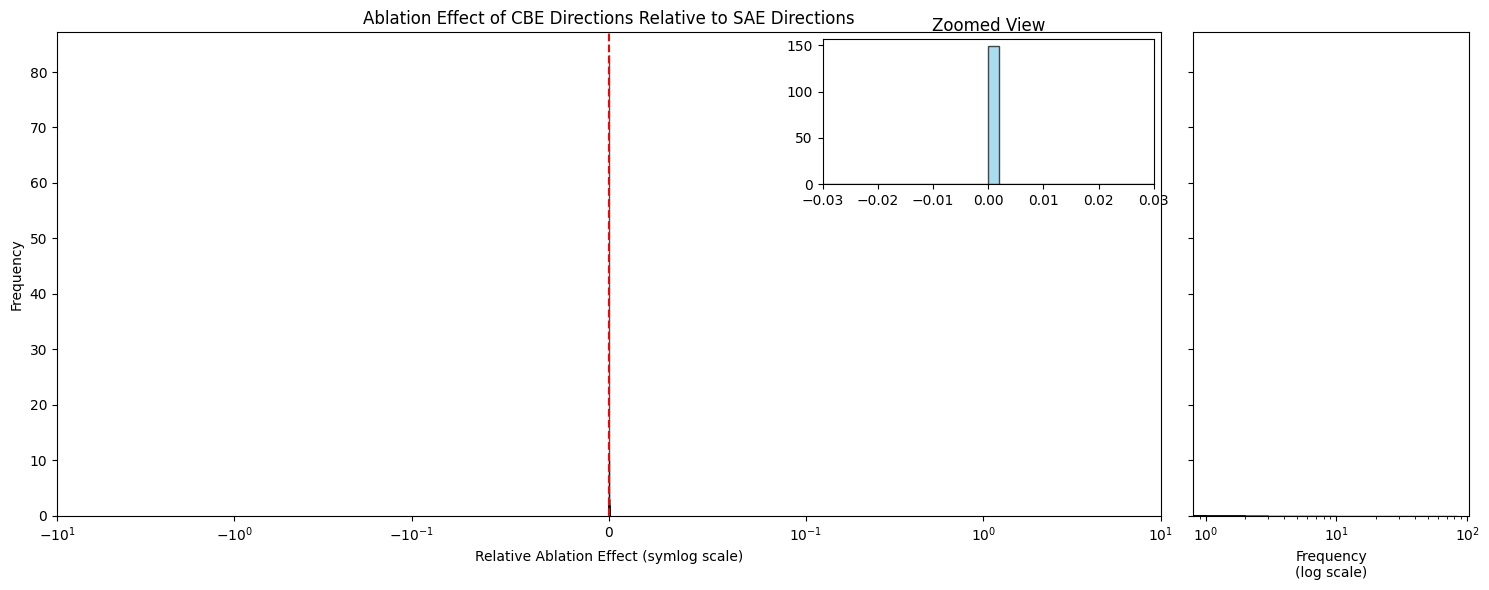

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import torch

def remove_lowest_element(lst):
    return [x for x in lst if x != min(lst)]

def plot_zoomed_histogram(all_relative_effects):
    # Convert to numpy array and remove lowest element
    data = np.array([x.item() if isinstance(x, torch.Tensor) else x for x in remove_lowest_element(all_relative_effects)])
    
    # Create the main figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [4, 1]})
    fig.subplots_adjust(wspace=0.05)  # reduce space between plots
    
    # Plot histogram on main axis (logarithmic scale)
    n, bins, patches = ax1.hist(data, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_xscale('symlog', linthresh=0.1)  # use symlog scale
    ax1.set_xlim(-10, 10)  # set x limits
    
    # Add mean line
    mean = np.mean(data)
    ax1.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.4f}')
    
    # Set labels and title for main plot
    ax1.set_xlabel('Relative Ablation Effect (symlog scale)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Ablation Effect of CBE Directions Relative to SAE Directions')
    ax1.legend()
    
    # Plot full range on the right axis
    ax2.hist(data, bins=100, alpha=0.7, color='skyblue', edgecolor='black', orientation='horizontal')
    ax2.set_ylim(ax1.get_ylim())  # match y limits with main plot
    ax2.set_xscale('log')  # use log scale for frequency
    ax2.set_xlabel('Frequency\n(log scale)')
    ax2.set_yticklabels([])  # remove y tick labels
    
    # Add an inset axes for zoomed view
    axins = inset_axes(ax1, width="30%", height="30%", loc='upper right')
    axins.hist(data, bins=100, range=(-0.1, 0.1), alpha=0.7, color='skyblue', edgecolor='black')
    axins.set_xlim(-0.03, 0.03)
    axins.set_title('Zoomed View')
    
    # Print statistics
    print("All relative effects:")
    print([torch.tensor(scalar) for scalar in all_relative_effects])
    print(f"Mean of all relative effects: {np.mean([torch.tensor(scalar).item() for scalar in all_relative_effects]):.4f}")
    print(f"Mean of relative effects (excluding lowest): {mean:.4f}")
    
    plt.tight_layout()
    plt.show()


plot_zoomed_histogram(all_relative_effects)

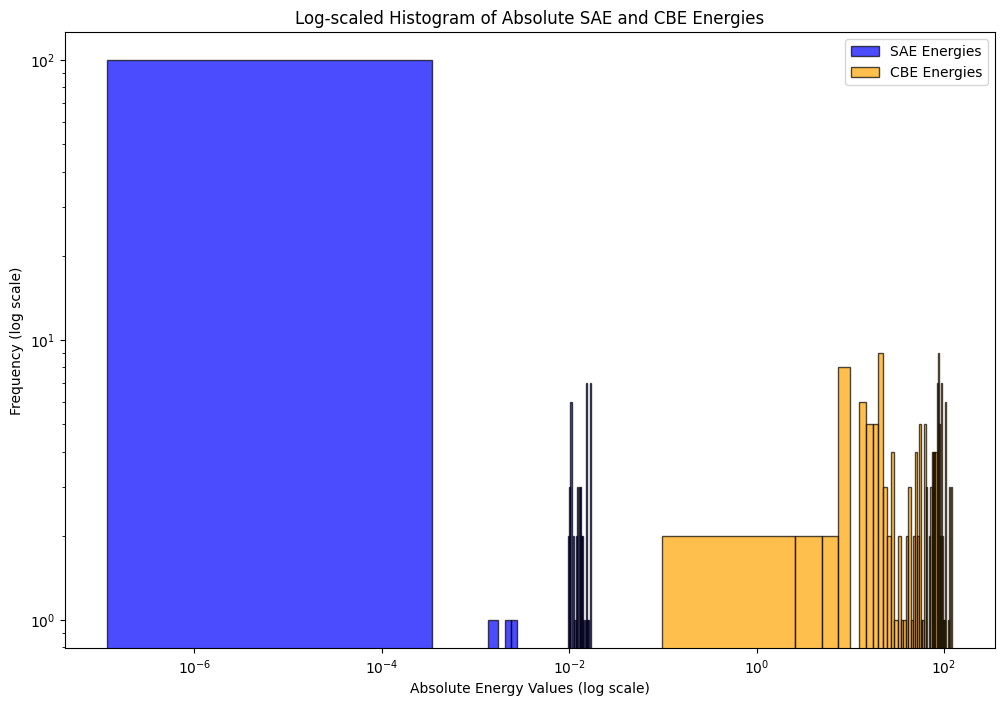

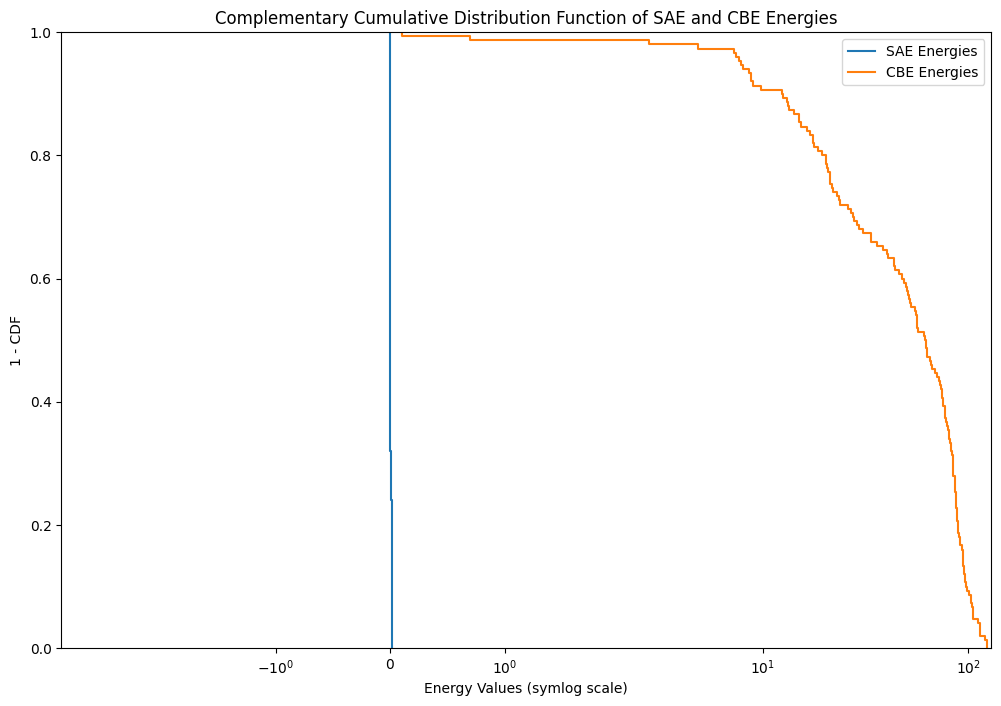

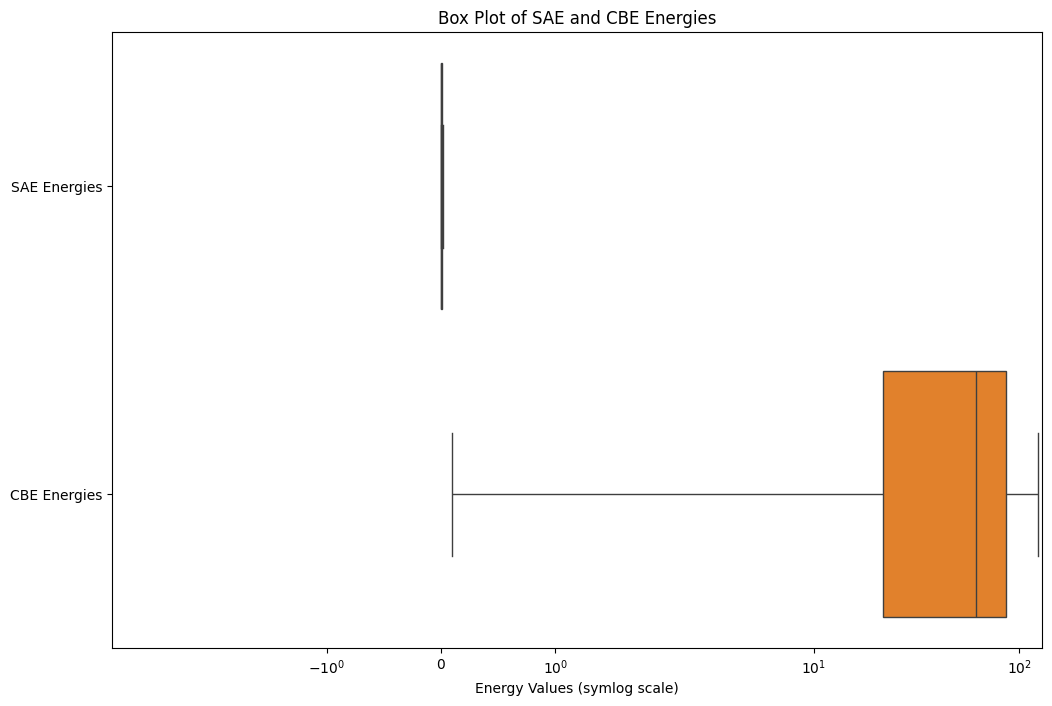

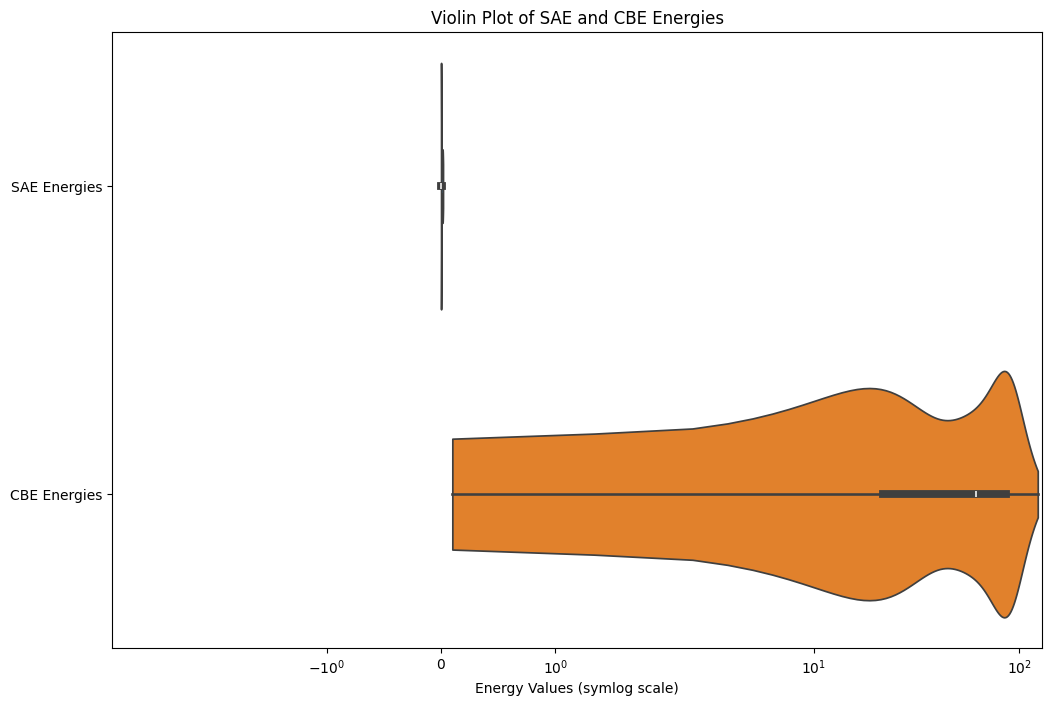

SAE Energies Summary:
Mean: 4.2633e-03
Median: 6.7996e-05
Std Dev: 6.3117e-03
Min: 1.1614e-07
Max: 1.7201e-02

CBE Energies Summary:
Mean: 5.7498e+01
Median: 6.1827e+01
Std Dev: 3.4003e+01
Min: 9.8731e-02
Max: 1.2289e+02

t-test results: t-statistic = -20.6393, p-value = 2.1745e-59


In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_energy_comparisons(sae_energies, cbe_energies):
    # Convert tensor data to numpy arrays

    # 1. Log-scaled histogram
    plt.figure(figsize=(12, 8))
    plt.hist(np.abs(sae_energies), bins=50, alpha=0.7, color='blue', edgecolor='black', label='SAE Energies', log=True)
    plt.hist(np.abs(cbe_energies), bins=50, alpha=0.7, color='orange', edgecolor='black', label='CBE Energies', log=True)
    plt.xscale('log')
    plt.legend()
    plt.xlabel('Absolute Energy Values (log scale)')
    plt.ylabel('Frequency (log scale)')
    plt.title('Log-scaled Histogram of Absolute SAE and CBE Energies')
    plt.show()

    # 2. Cumulative distribution function (CDF) plot
    plt.figure(figsize=(12, 8))
    sns.ecdfplot(data=sae_energies, label='SAE Energies', complementary=True)
    sns.ecdfplot(data=cbe_energies, label='CBE Energies', complementary=True)
    plt.xscale('symlog')
    plt.legend()
    plt.xlabel('Energy Values (symlog scale)')
    plt.ylabel('1 - CDF')
    plt.title('Complementary Cumulative Distribution Function of SAE and CBE Energies')
    plt.show()

    # 3. Box plot
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=[sae_energies, cbe_energies], orient='h')
    plt.xscale('symlog')
    plt.yticks([0, 1], ['SAE Energies', 'CBE Energies'])
    plt.xlabel('Energy Values (symlog scale)')
    plt.title('Box Plot of SAE and CBE Energies')
    plt.show()

    # 4. Violin plot
    plt.figure(figsize=(12, 8))
    sns.violinplot(data=[sae_energies, cbe_energies], orient='h', cut=0)
    plt.xscale('symlog')
    plt.yticks([0, 1], ['SAE Energies', 'CBE Energies'])
    plt.xlabel('Energy Values (symlog scale)')
    plt.title('Violin Plot of SAE and CBE Energies')
    plt.show()

    # 5. Summary statistics
    print("SAE Energies Summary:")
    print(f"Mean: {np.mean(sae_energies):.4e}")
    print(f"Median: {np.median(sae_energies):.4e}")
    print(f"Std Dev: {np.std(sae_energies):.4e}")
    print(f"Min: {np.min(sae_energies):.4e}")
    print(f"Max: {np.max(sae_energies):.4e}")
    print("\nCBE Energies Summary:")
    print(f"Mean: {np.mean(cbe_energies):.4e}")
    print(f"Median: {np.median(cbe_energies):.4e}")
    print(f"Std Dev: {np.std(cbe_energies):.4e}")
    print(f"Min: {np.min(cbe_energies):.4e}")
    print(f"Max: {np.max(cbe_energies):.4e}")

    # 6. Statistical test
    t_stat, p_value = stats.ttest_ind(sae_energies, cbe_energies)
    print(f"\nt-test results: t-statistic = {t_stat:.4f}, p-value = {p_value:.4e}")


plot_energy_comparisons(sae_energies, cbe_energies)

## Compare cosine similarities of CBE directions and SAE directions for activation examples

In [10]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compute_direction_similarities(directions1, directions2):
    
    # Normalize directions
    directions1_norm = directions1 / np.linalg.norm(directions1, axis=1, keepdims=True)
    directions2_norm = directions2 / np.linalg.norm(directions2, axis=1, keepdims=True)
    
    # Compute cosine similarities
    similarities = cosine_similarity(directions1_norm, directions2_norm)
    
    return similarities

def generate_random_directions(shape, n_sets=100):
    return torch.randn(n_sets, *shape)

def compute_random_mean_similarity(shape, n_sets=100):
    random_directions1 = generate_random_directions(shape, n_sets)
    random_directions2 = generate_random_directions(shape, n_sets)
    
    random_similarities = torch.tensor([
        compute_direction_similarities(rd1, rd2).mean()
        for rd1, rd2 in zip(random_directions1, random_directions2)
    ])
    
    return random_similarities.mean().item(), random_similarities.std().item()

def analyze_direction_alignment(cbe_directions, sae_directions, n_random=1000):
    # Compute similarities between CBE and SAE directions
    similarities = compute_direction_similarities(cbe_directions, sae_directions)
    
    # Convert to NumPy for consistency
    cbe_directions = to_numpy(cbe_directions)
    sae_directions = to_numpy(sae_directions)
    
    # Generate random directions for baseline
    random_directions = np.random.randn(*cbe_directions.shape)
    random_similarities = compute_direction_similarities(cbe_directions, random_directions)
    
    # Compute statistics
    max_similarities = np.max(similarities, axis=1)
    mean_similarity = np.mean(similarities)
    random_mean_similarity = np.mean(random_similarities)

    
    print(f"Mean similarity between CBE and SAE directions: {mean_similarity:.4f}")
    print(f"Mean similarity with random directions: {random_mean_similarity:.4f}")
    
    return similarities, max_similarities

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compare_cbe_sae_vectors(cbe_directions, sae_directions):
    similarities = np.zeros((cbe_directions.shape[0], sae_directions.shape[0]))
    
    # Print the similarities
    print("\nCosine Similarities between CBE and SAE vectors:")
    print("-----------------------------------------------")
    for i in range(cbe_directions.shape[0]):
        for j in range(sae_directions.shape[0]):
            norm1 = cbe_directions[i] / np.linalg.norm(cbe_directions[i])
            norm2 = sae_directions[j] / np.linalg.norm(sae_directions[j])
            sim = np.dot(norm1,norm2)
            similarities[i, j] = sim
            print(f"CBE vector {i+1} vs SAE vector {j+1}: {sim:.4f}")
        print()  # Add a blank line between CBE vectors for readability
    
    # Print summary statistics
    print("Summary Statistics:")
    print(f"Mean similarity: {np.mean(similarities):.4f}")
    print(f"Median similarity: {np.median(similarities):.4f}")
    print(f"Min similarity: {np.min(similarities):.4f}")
    print(f"Max similarity: {np.max(similarities):.4f}")
    
    return similarities

def compare_cbe_sae_vectors_no_print(cbe_directions, sae_directions):
    similarities = np.zeros((cbe_directions.shape[0], sae_directions.shape[0]))
    for i in range(cbe_directions.shape[0]):
        for j in range(sae_directions.shape[0]):
            norm1 = cbe_directions[i] / np.linalg.norm(cbe_directions[i])
            norm2 = sae_directions[j] / np.linalg.norm(sae_directions[j])
            sim = np.dot(norm1,norm2)
            similarities[i, j] = sim
    
    return similarities

def get_max_similarity_values(similarity_matrix):
    max_similarities = np.max(similarity_matrix, axis=1)
    max_similarity_matrix = max_similarities.reshape(-1, 1)
    return max_similarity_matrix

def to_numpy(tensor):
    return tensor.cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor


Processing prompts: 100%|██████████| 200/200 [1:02:37<00:00, 18.79s/it]


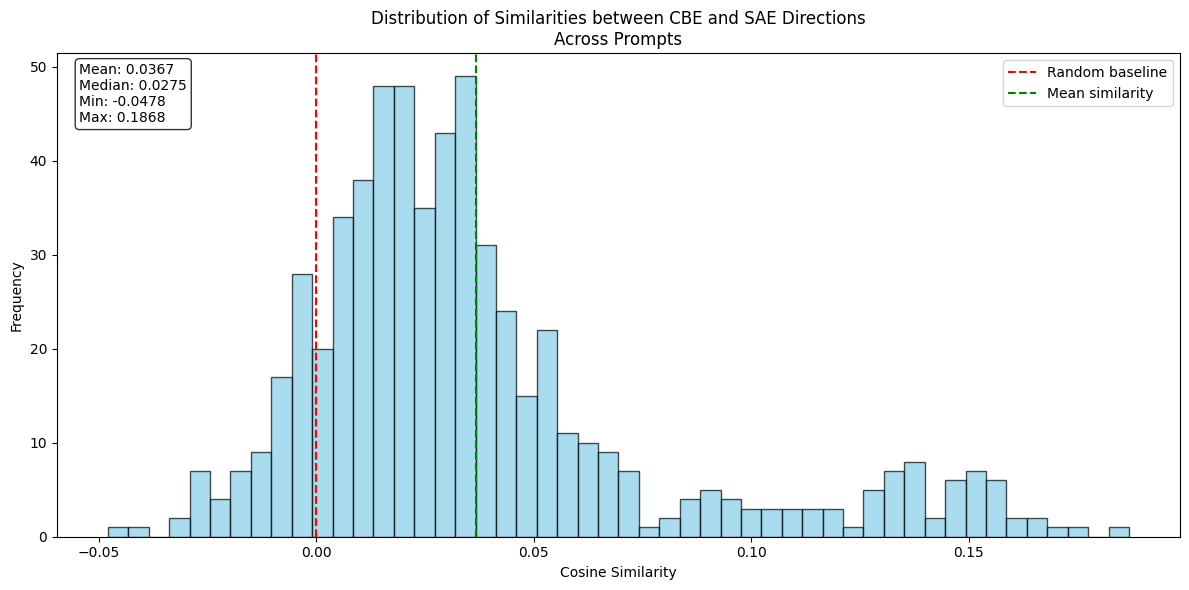

Total number of similarity comparisons: 600
Mean similarity: 0.0367
Median similarity: 0.0275
Min similarity: -0.0478
Max similarity: 0.1868


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

prompts = get_short_sentences(max_length=10, num_sentences=100)

def multi_prompt_comparison(model, sae, layer_index, dataset_loader, prompts, k_sae=3, k_cbe=3):
    all_similarities = []
    for _ in tqdm(range(len(prompts)), desc="Processing prompts"):
        prompt = prompts.pop()
        
        # Get SAE directions
        tokens = model.to_tokens(prompt, prepend_bos=True)
        _, cache = model.run_with_cache(tokens)
        last_token_activation = cache[sae.cfg.hook_name][:, -1, :]
        sae_directions = get_top_k_active_directions(sae, last_token_activation, k_sae)
        
        # Get CBE directions
        causal_basis,_ = extract_causal_bases(
            model=model,
            activation=last_token_activation,
            layer_index=layer_index,
            dataset_loader=dataset_loader,
            k=k_cbe,
            max_iter=300,
            mode="mean"
        )
        
        # Compare directions
        cbe_directions = to_numpy(causal_basis.vectors).T
        sae_directions = to_numpy(sae_directions).T
        similarities = compare_cbe_sae_vectors_no_print(cbe_directions, sae_directions)
        max_similarities = get_max_similarity_values(similarities)
        
        all_similarities.extend(max_similarities.flatten())
    
    return np.array(all_similarities)

# Run the multi-prompt comparison
dataset_loader = create_dataset_loader(prompts, model, batch_size=2)
layer_index=8
all_similarities = multi_prompt_comparison(model, sae, layer_index, dataset_loader, prompts)

# Plot the distribution of similarities
plt.figure(figsize=(12, 6))
plt.hist(all_similarities, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0, color='r', linestyle='--', label='Random baseline')
plt.axvline(np.mean(all_similarities), color='g', linestyle='--', label='Mean similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title(f'Distribution of Similarities between CBE and SAE Directions\nAcross Prompts')
plt.legend()

# Add summary statistics to the plot
plt.text(0.02, 0.98, f"Mean: {np.mean(all_similarities):.4f}\n"
                     f"Median: {np.median(all_similarities):.4f}\n"
                     f"Min: {np.min(all_similarities):.4f}\n"
                     f"Max: {np.max(all_similarities):.4f}",
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig("multi_prompt_cbe_sae_similarity_distribution.png")
plt.show()

print(f"Total number of similarity comparisons: {len(all_similarities)}")
print(f"Mean similarity: {np.mean(all_similarities):.4f}")
print(f"Median similarity: {np.median(all_similarities):.4f}")
print(f"Min similarity: {np.min(all_similarities):.4f}")
print(f"Max similarity: {np.max(all_similarities):.4f}")

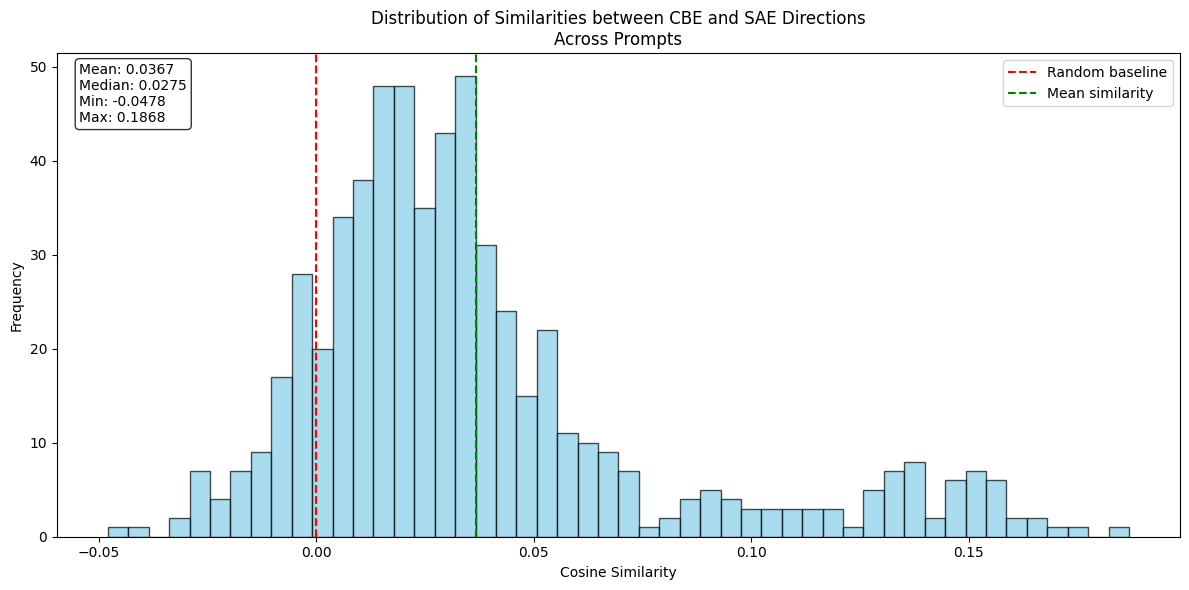

Total number of similarity comparisons: 600
Mean similarity: 0.0367
Median similarity: 0.0275
Min similarity: -0.0478
Max similarity: 0.1868


In [19]:
# Plot the distribution of similarities
plt.figure(figsize=(12, 6))
plt.hist(all_similarities, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0, color='r', linestyle='--', label='Random baseline')
plt.axvline(np.mean(all_similarities), color='g', linestyle='--', label='Mean similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title(f'Distribution of Similarities between CBE and SAE Directions\nAcross Prompts')
plt.legend()

# Add summary statistics to the plot
plt.text(0.02, 0.98, f"Mean: {np.mean(all_similarities):.4f}\n"
                     f"Median: {np.median(all_similarities):.4f}\n"
                     f"Min: {np.min(all_similarities):.4f}\n"
                     f"Max: {np.max(all_similarities):.4f}",
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig("multi_prompt_cbe_sae_similarity_distribution.png")
plt.show()

print(f"Total number of similarity comparisons: {len(all_similarities)}")
print(f"Mean similarity: {np.mean(all_similarities):.4f}")
print(f"Median similarity: {np.median(all_similarities):.4f}")
print(f"Min similarity: {np.min(all_similarities):.4f}")
print(f"Max similarity: {np.max(all_similarities):.4f}")